|Traitement|Scratch|VGG16|InceptionV3|Xception 
|-----|:-------:|:------:|:------:|:------ :
|Base|
|Avec Data Augmentation|
|Avec Data Augmentation et FineTuning|

# 1. Initialisation

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
plt.style.use("default")

from sklearn.model_selection import train_test_split

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications import VGG16
from keras.applications import InceptionV3
from keras.applications import Xception

In [7]:
# Création des fonctions

def get_dataframe(path, n_breeds=12):
    dogs_lst = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            dogs_lst.append(os.path.join(dirname, filename))

    # Je stocke dans un dataframe
    dogs_raw = pd.DataFrame(dogs_lst, columns=['uri'])

    # J'extrais la race
    dogs_raw['breeds'] = dogs_raw.uri.str.split('/').str.get(5).str.slice(10)
    
    # Délimitation du nombre de race
    top_breeds = dogs_raw.groupby('breeds').count().sort_values(by='uri', ascending=False).head(n_breeds).reset_index().breeds.to_list()
    dogs = pd.DataFrame()
    for b in top_breeds:
        dogs = dogs.append(dogs_raw[dogs_raw.breeds == b])

    return dogs


def get_batch_size(gen):
    lst = []
    dict = {}
    
    # Test des nombres entiers et intégration dans un dictionnaire
    for i in range(1,40):
        dict[i] = gen % i
    
    # Récupération du plus grand nombre entiers
    for key, value in dict.items():
        if value == 0:
            lst.append(key)

    return max(lst)


def get_model(act_function):
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(256, activation=act_function))
    model.add(Dense(len(train_gen.class_indices), activation='softmax'))
    return model


def plot_activation_functions(history, subtitle):
    # Extraction des historique
    val_loss = {k:v.history['val_loss'] for k,v in activation_results.items()}
    val_acc = {k:v.history['val_accuracy'] for k,v in activation_results.items()}
    # Conversion en df
    val_loss_curves = pd.DataFrame(val_loss)
    val_acc_curves = pd.DataFrame(val_acc)
    # Graphique
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    ax[0].plot(val_loss_curves.leaky_relu, label='leaky_relu')
    ax[0].plot(val_loss_curves.relu, label='relu')
    ax[0].plot(val_loss_curves.sigmoid, label='sigmoid')
    ax[0].plot(val_loss_curves.tanh, label='tanh')
    ax[0].set_title('val_loss | ' + subtitle)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Val_loss')
    ax[0].legend()

    ax[1].plot(val_acc_curves.leaky_relu, label='leaky_relu')
    ax[1].plot(val_acc_curves.relu, label='relu')
    ax[1].plot(val_acc_curves.sigmoid, label='sigmoid')
    ax[1].plot(val_acc_curves.tanh, label='tanh')
    ax[1].set_title('val_accuracy | ' + subtitle)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('val_accuracy')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_' + subtitle + '_activation_function.png',
                    transparent=True)
    return None


def plot_effect(history_std, history_modified, title, subtitle):
    # Conversion en dataframe
    df_model_std = pd.DataFrame(history_std.history['val_accuracy'], columns=["model_std"])
    df_model_modified = pd.DataFrame(history_modified.history['val_accuracy'], columns=[title])

    # Tracage
    pd.merge(df_model_std, df_model_modified, right_index=True, left_index=True).plot()
    plt.title(title + "_" + subtitle)
    plt.xlabel("epoch")
    plt.ylabel("val_accuracy")
    plt.savefig('./cnn_transfer_learning_ ' + subtitle + '_' + title + '.png',
                transparent=True)
    plt.show()
    return None


def plot_result_fitting(history, subtitle, title, n_breeds):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax[0].set_title('Accuracy | ' + subtitle + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label = 'val_loss')
    ax[1].set_title('Loss function | ' + subtitle + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_ ' + subtitle + '_' + title + '_' + str(n_breeds) + '_breeds_results.png',
                transparent=True)
    return

# 2. Import des données et paramétrage
En phase exploratoire, je limite à 10% le nombre de races à tester (soit 12%)

In [3]:
n_breeds = 12
# Création du dataframe et sélection des 12 races les plus fournies en images
dogs = get_dataframe('../input/stanford-dogs-dataset/images', n_breeds)
print(f"Nous avons {dogs.breeds.nunique()} races sélectionnées pour la phase d'expérimentation.")
dogs

Nous avons 12 races sélectionnées pour la phase d'expérimentation.


,uri,breeds
5084,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
5085,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
5086,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
5087,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
5088,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
...,...,...
15601,../input/stanford-dogs-dataset/images/Images/n...,Tibetan_terrier
15602,../input/stanford-dogs-dataset/images/Images/n...,Tibetan_terrier
15603,../input/stanford-dogs-dataset/images/Images/n...,Tibetan_terrier
15604,../input/stanford-dogs-dataset/images/Images/n...,Tibetan_terrier


In [4]:
# Séparation des données d'entrainements et de tests
train, test = train_test_split(dogs, test_size=0.2, random_state=42)

# Séparation des données d'entrainements et de validation
train, val = train_test_split(train, test_size=0.2, random_state=42)

Optimisation des générateurs :
* Pour des raisons d'économies de calcul, je réduis toutes les images à 150*150 pixels,
* Il est important que batch_size soit un nombre entier du jeu de test. Si ce n'est pas le cas du jeu d'entrainement et du jeu de validation, ce n'est pas bien grave car l'image sera retraitée dans une autre epoch,
* shuffle sera égal à True sur les jeu d'entraînement et de validation, et sera égal à False sur le jeu de test. Cela me permettra de faire correspondre les prédictions en sortie avec les identifiants.
* L'augmentation des données ne se fera que sur les données d'entraînements. Cela consiste à modifier une image de manière aléatoire (rotation, zoom, mirroir) de manière à ce que l'algorithmes ne voit qu'une fois la même image.


In [5]:
### Paramétrage
x = 'uri'
y = 'breeds'
target_size = (150, 150)
seed = 42

train_batch_size = get_batch_size(len(train))
val_batch_size = get_batch_size(len(val))
test_batch_size = get_batch_size(len(test))

train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Sans augmentation des données
train_gen = train_datagen.flow_from_dataframe(
                  train,
                  x_col='uri',
                  y_col='breeds',
                  target_size=target_size,
                  batch_size=train_batch_size,
                  seed=seed
                  )


# Avec augmentation des données
train_gen_data_aug = train_datagen_aug.flow_from_dataframe(
                          train,
                          x_col='uri',
                          y_col='breeds',
                          target_size=target_size,
                          batch_size=train_batch_size,
                          seed=seed
                          )

val_gen = val_test_datagen.flow_from_dataframe(
                  val,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=val_batch_size,
                  seed=seed
                  )

test_gen = val_test_datagen.flow_from_dataframe(
                  test,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=test_batch_size,
                  seed=seed,
                  shuffle=False
                  )

Found 1694 validated image filenames belonging to 12 classes.
Found 1694 validated image filenames belonging to 12 classes.
Found 424 validated image filenames belonging to 12 classes.
Found 530 validated image filenames belonging to 12 classes.


# 3. Evaluation du modèle InceptionV3
## 3.1 Paramétrage

In [6]:
### Paramétrage de la configuration
# Titre documents de sortie
subtitle = "Xception"

# Choix du modèle convolutionnel de base, avec gel de la base
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
print('Nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))
conv_base.trainable = False
print('Nombre de poids entraînable après gel de la base convolutionnelle :', len(conv_base.trainable_weights))

83689472/83683744 [==============================] - 1s 0us/step
Nombre de poids entraînable avant gel de la base convolutionnelle : 154
Nombre de poids entraînable après gel de la base convolutionnelle : 0


## 3-3. Choix des ajustements
### 3-3-1. Formation du modèle standard comme point de comparaison

Epoch 1/40
77/77 [==============================] - 16s 209ms/step - loss: 3.7200 - accuracy: 0.7043 - val_loss: 1.8141 - val_accuracy: 0.7689
Epoch 2/40
77/77 [==============================] - 9s 114ms/step - loss: 0.7544 - accuracy: 0.8436 - val_loss: 1.2399 - val_accuracy: 0.7689
Epoch 3/40
77/77 [==============================] - 9s 118ms/step - loss: 0.2726 - accuracy: 0.9185 - val_loss: 1.1907 - val_accuracy: 0.7830
Epoch 4/40
77/77 [==============================] - 9s 123ms/step - loss: 0.1184 - accuracy: 0.9634 - val_loss: 1.3728 - val_accuracy: 0.7689
Epoch 5/40
77/77 [==============================] - 9s 114ms/step - loss: 0.1014 - accuracy: 0.9687 - val_loss: 1.3899 - val_accuracy: 0.7736
Epoch 6/40
77/77 [==============================] - 9s 112ms/step - loss: 0.0737 - accuracy: 0.9758 - val_loss: 1.5284 - val_accuracy: 0.7759
Epoch 7/40
77/77 [==============================] - 9s 115ms/step - loss: 0.1771 - accuracy: 0.9569 - val_loss: 1.6186 - val_accuracy: 0.7948
Epoch

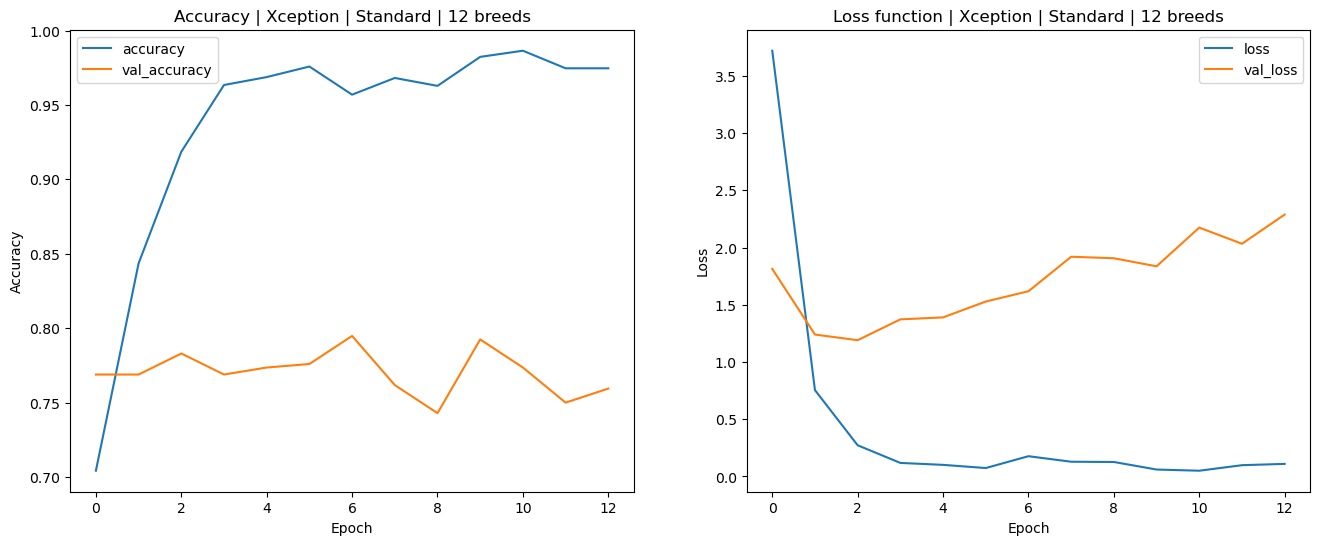

In [8]:
epochs = 40
verbose = 1
early_stopping_monitor = EarlyStopping(patience=10)

model_std = get_model(act_function='relu')
model_std.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

history_std = model_std.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose, callbacks = [early_stopping_monitor])

title = "Standard"
plot_result_fitting(history_std, subtitle, title, n_breeds)


### 3-3-2. Mesure de l'effet Data Augmentation

Epoch 1/40
77/77 [==============================] - 20s 256ms/step - loss: 4.3694 - accuracy: 0.5519 - val_loss: 0.8952 - val_accuracy: 0.7288
Epoch 2/40
77/77 [==============================] - 18s 228ms/step - loss: 1.1318 - accuracy: 0.6529 - val_loss: 0.7820 - val_accuracy: 0.7830
Epoch 3/40
77/77 [==============================] - 18s 229ms/step - loss: 0.9938 - accuracy: 0.6795 - val_loss: 0.8177 - val_accuracy: 0.7571
Epoch 4/40
77/77 [==============================] - 18s 229ms/step - loss: 0.8658 - accuracy: 0.7143 - val_loss: 0.7430 - val_accuracy: 0.7642
Epoch 5/40
77/77 [==============================] - 18s 235ms/step - loss: 0.8210 - accuracy: 0.7285 - val_loss: 0.8228 - val_accuracy: 0.7689
Epoch 6/40
77/77 [==============================] - 17s 223ms/step - loss: 0.8811 - accuracy: 0.7166 - val_loss: 0.7481 - val_accuracy: 0.7453
Epoch 7/40
77/77 [==============================] - 18s 234ms/step - loss: 0.7989 - accuracy: 0.7379 - val_loss: 0.7166 - val_accuracy: 0.7972

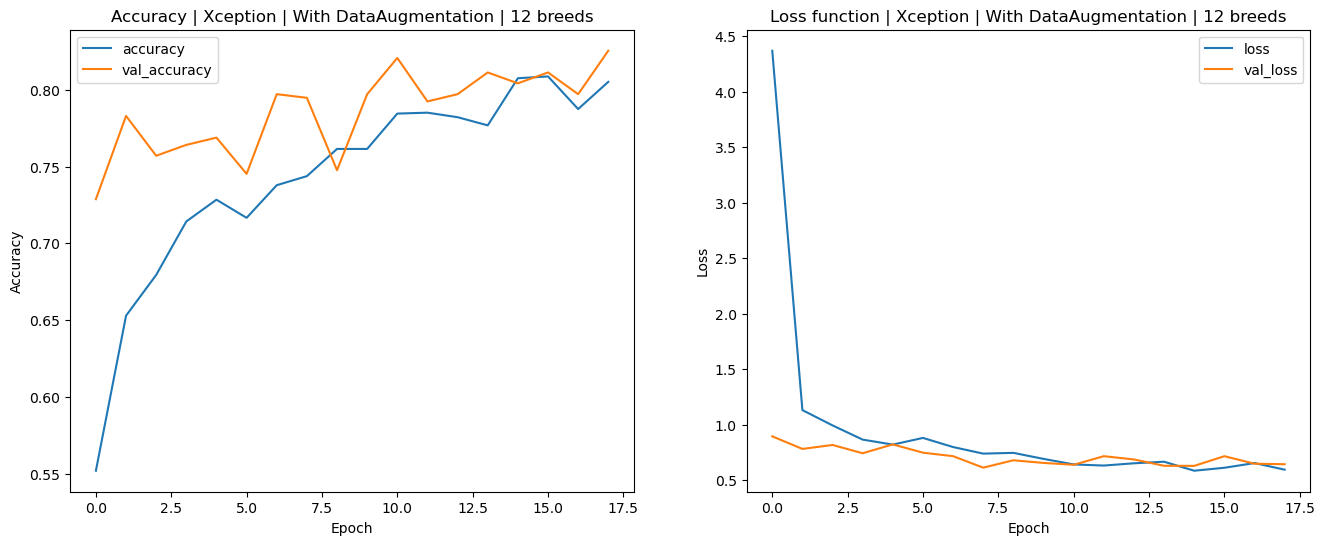

In [9]:
model_modified = get_model(act_function='relu')
model_modified.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history_modified = model_modified.fit(train_gen_data_aug, validation_data=val_gen, epochs=epochs, verbose=verbose, callbacks = [early_stopping_monitor])

title = "With DataAugmentation"

plot_result_fitting(history_modified, subtitle, title, n_breeds)

### 3-3-4. Mesure de l'effet Fine Tuning
Pour mesurer cela, je dégèle la dernière couche de l'algorithme pour entraînement.

In [10]:
for layer in conv_base.layers:
   print(layer.name)

input_1
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d
block2_pool
batch_normalization
add
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_1
block3_pool
batch_normalization_1
add_1
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_2
block4_pool
batch_normalization_2
add_2
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_3
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_4
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act
block7_sepconv2
block7_sepconv2_

Rappel du nombre de poids entraînable avant gel de la base convolutionnelle : 154
Nombre de poids entraînable après dégel de la dernière couche base convolutionnelle : 29
Epoch 1/40
77/77 [==============================] - 19s 246ms/step - loss: 2.3281 - accuracy: 0.2869 - val_loss: 3.5045 - val_accuracy: 0.5542
Epoch 2/40
77/77 [==============================] - 18s 236ms/step - loss: 1.3471 - accuracy: 0.5726 - val_loss: 0.9865 - val_accuracy: 0.7170
Epoch 3/40
77/77 [==============================] - 18s 233ms/step - loss: 0.9766 - accuracy: 0.6712 - val_loss: 1.0328 - val_accuracy: 0.7241
Epoch 4/40
77/77 [==============================] - 17s 226ms/step - loss: 0.9050 - accuracy: 0.7025 - val_loss: 0.9826 - val_accuracy: 0.7193
Epoch 5/40
77/77 [==============================] - 18s 235ms/step - loss: 0.7772 - accuracy: 0.7591 - val_loss: 1.3267 - val_accuracy: 0.6179
Epoch 6/40
77/77 [==============================] - 19s 244ms/step - loss: 0.7025 - accuracy: 0.7751 - val_loss: 1

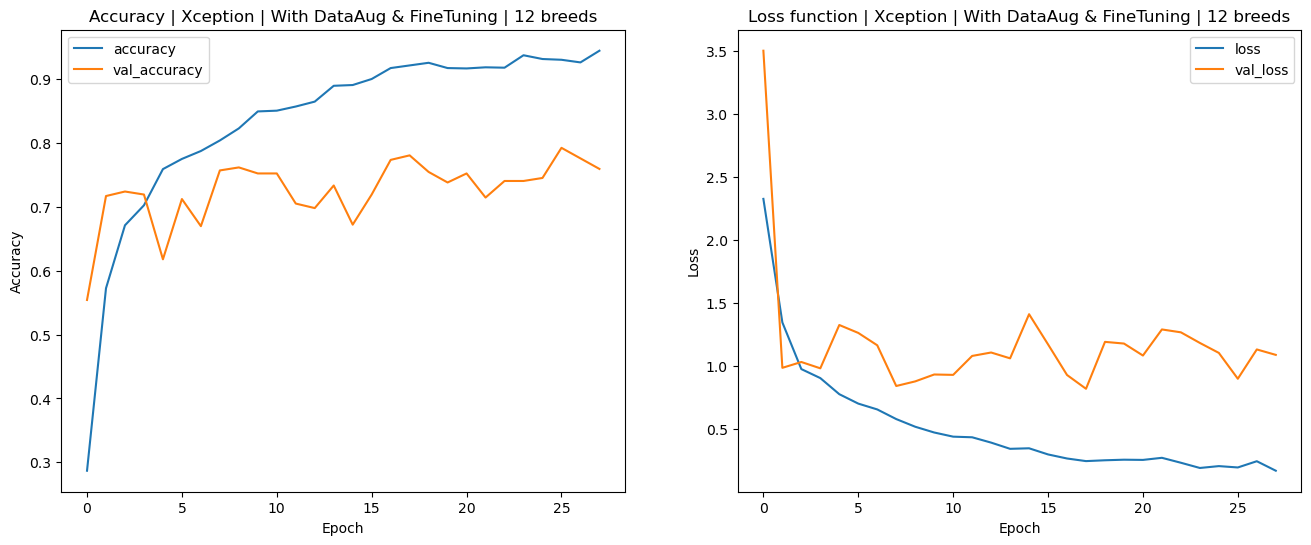

In [11]:
# Avec fine tuning
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
print('Rappel du nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))

for layer in conv_base.layers[:-24]:
    layer.trainable = False
for layer in conv_base.layers[-24:]:
    layer.trainable = True
        
print('Nombre de poids entraînable après dégel de la dernière couche base convolutionnelle :', len(conv_base.trainable_weights))

# Avec fine tuning
model_modified = get_model(act_function='relu')
model_modified.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history_modified = model_modified.fit(train_gen_data_aug, validation_data=val_gen, epochs=epochs, verbose=verbose, callbacks = [early_stopping_monitor])

title = "With DataAug & FineTuning"

plot_result_fitting(history_modified, subtitle, title, n_breeds)

### 3-3-5. Conclusion sur les différentes mesures
* La data augmentation augmente les performance du modèle mais le rend légèrement moins stable
* Batch normalization dégrade le modèle
* Dropout avec une valeur de 0.2 maintient le modèle, mais diminue sa stabilité, Dropout avec une valeur de 0.5 dégrade le modèle et le rend instable.
* Contre mon attente, le fine tuning dégrade fortement le modèle, peut-être il y a un problème ?

## 3-4. Evaluation

In [12]:
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
print('Nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))
conv_base.trainable = False
print('Nombre de poids entraînable après gel de la base convolutionnelle :', len(conv_base.trainable_weights))

model_final = Sequential()
model_final.add(conv_base)
model_final.add(Flatten())
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(len(train_gen_data_aug.class_indices), activation='softmax'))

# Résumé du modèle
model_final.summary()

Nombre de poids entraînable avant gel de la base convolutionnelle : 154
Nombre de poids entraînable après gel de la base convolutionnelle : 0
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_7 (Dense)              (None, 12)                3084      
Total params: 33,972,020
Trainable params: 13,110,540
Non-trainable params: 20,861,480
_________________________________________________________________


----

Epoch 1/500
77/77 [==============================] - 20s 260ms/step - loss: 4.9883 - accuracy: 0.5708 - val_loss: 0.9953 - val_accuracy: 0.6934
Epoch 2/500
77/77 [==============================] - 20s 266ms/step - loss: 1.1111 - accuracy: 0.6765 - val_loss: 0.7594 - val_accuracy: 0.7665
Epoch 3/500
77/77 [==============================] - 18s 234ms/step - loss: 0.9189 - accuracy: 0.7137 - val_loss: 0.8266 - val_accuracy: 0.7500
Epoch 4/500
77/77 [==============================] - 19s 244ms/step - loss: 0.8995 - accuracy: 0.6924 - val_loss: 0.7450 - val_accuracy: 0.7712
Epoch 5/500
77/77 [==============================] - 19s 241ms/step - loss: 0.8364 - accuracy: 0.7166 - val_loss: 0.7620 - val_accuracy: 0.7877
Epoch 6/500
77/77 [==============================] - 18s 238ms/step - loss: 0.8117 - accuracy: 0.7202 - val_loss: 0.7654 - val_accuracy: 0.7807
Epoch 7/500
77/77 [==============================] - 17s 224ms/step - loss: 0.7626 - accuracy: 0.7391 - val_loss: 0.7831 - val_accuracy:

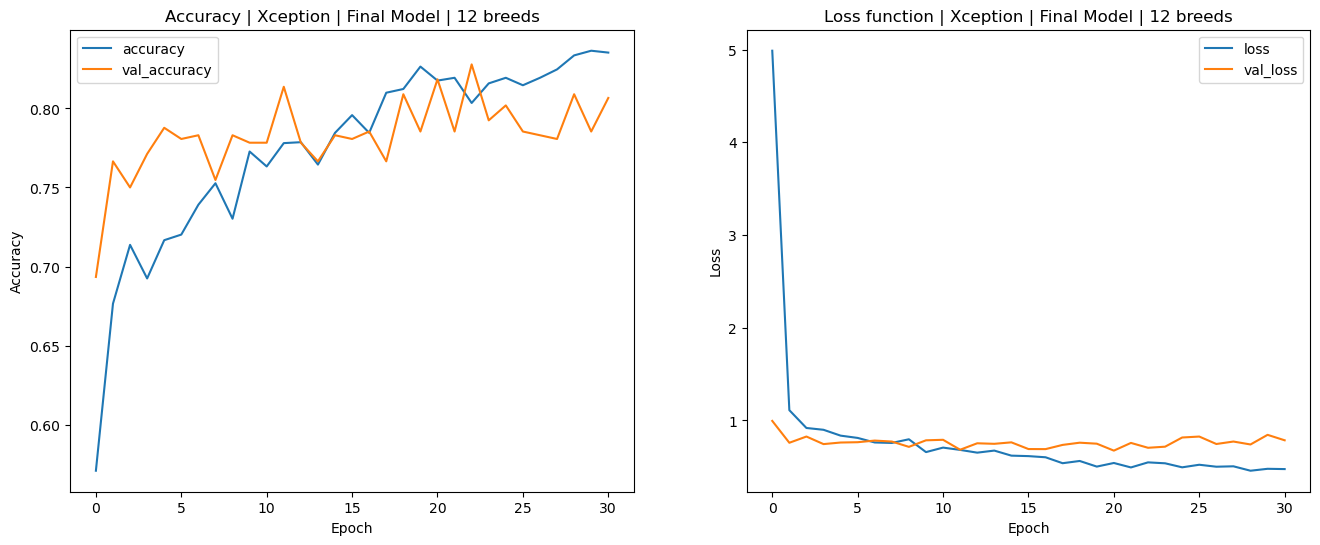

In [13]:
model_final.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=10)
model_save = ModelCheckpoint('best_model_' + subtitle + '.hdf5', save_best_only=True)

history = model_final.fit(train_gen_data_aug, validation_data=val_gen, epochs=500, callbacks = [early_stopping_monitor, model_save])
title = 'Final Model'
plot_result_fitting(history, subtitle, title, n_breeds)

In [14]:
model_final.evaluate(test_gen)

53/53 [==============================] - 3s 65ms/step - loss: 0.7795 - accuracy: 0.7868


[0.7795224189758301, 0.7867924571037292]

# 4. Evaluation du modèle avec 60 races (50 %)

In [ ]:
n_breeds = 60
# Création du dataframe avec 50 races
dogs = get_dataframe('../input/stanford-dogs-dataset/images', n_breeds)
print(f"Nous avons {dogs.breeds.nunique()} races sélectionnées pour la montée en charge.")

# Séparation des données d'entrainements et de tests
train, test = train_test_split(dogs, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

### Paramétrage
x = 'uri'
y = 'breeds'
target_size = (150, 150)
seed = 42

train_batch_size = get_batch_size(len(train))
val_batch_size = get_batch_size(len(val))
test_batch_size = get_batch_size(len(test))

train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Avec augmentation des données
train_gen_data_aug = train_datagen_aug.flow_from_dataframe(
                          train,
                          x_col='uri',
                          y_col='breeds',
                          target_size=target_size,
                          batch_size=train_batch_size,
                          seed=seed
                          )

val_gen = val_test_datagen.flow_from_dataframe(
                  val,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=val_batch_size,
                  seed=seed
                  )

test_gen = val_test_datagen.flow_from_dataframe(
                  test,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=test_batch_size,
                  seed=seed,
                  shuffle=False
                  )

conv_base = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
print('Nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))
conv_base.trainable = False
print('Nombre de poids entraînable après gel de la base convolutionnelle :', len(conv_base.trainable_weights))

model_final = Sequential()
model_final.add(conv_base)
model_final.add(Flatten())
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(len(train_gen_data_aug.class_indices), activation='softmax'))

model_final.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=10)
model_save = ModelCheckpoint('best_model_' + subtitle + '.hdf5', save_best_only=True)

history = model_final.fit(train_gen_data_aug, validation_data=val_gen, epochs=500, callbacks = [early_stopping_monitor, model_save])

title = 'Final Model'
plot_result_fitting(history, subtitle, title, n_breeds)

model_final.evaluate(test_gen)